Global Surrogate Model 
Testing creating a more easily interpretable global surrogate model from the XGBoost model

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


os.getcwd()
ames_geo = pd.read_csv(r"C:\users\willf\OneDrive\Documents\NYDSA\Machine Learning Project\Machine Learning Project Proposal\ames_geo_final.csv", keep_default_na=False)

In [2]:
# Drop unknown, identifier, addresses, sale-price-related and one of highly correlated columns

ames_geo_mlprep = ames_geo.drop(columns=['Unnamed: 0', 'PID', 'Prop_Addr','LogSalePrice',  
                                         'TotRmsAbvGrd', 'NmbrBRs', 'FireplaceQu', 'GarageCond', 'PoolQC'])

ames_geo_mlprep.columns

Index(['GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'Functional', 'Fireplaces', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'Scr

------------------------Feature Engineering Etc. ------------------------------------------

In [3]:
# Change GarageYrBlt nulls from 'None' back to null and then impute nulls with YearBuilt

ames_geo_mlprep['GarageYrBlt'] = ames_geo_mlprep['GarageYrBlt'].replace('None', pd.NA)

ames_geo_mlprep['GarageYrBlt'] = ames_geo_mlprep['GarageYrBlt'].fillna(ames_geo_mlprep['YearBuilt'])


In [4]:
# Get GarageYrBlt as int 
import re
import pandas as pd

# Define a function to remove '.0' at the end of a string if it exists
def remove_decimal_zero(x):
    if '.' in x and x.endswith('.0'):
        return x[:-2]
    return x

# Apply the function to the 'GarageYrBlt' column
ames_geo_mlprep['GarageYrBlt'] = ames_geo_mlprep['GarageYrBlt'].astype(str).apply(remove_decimal_zero).astype(int)

ames_geo_mlprep[ames_geo_mlprep['GarageYrBlt']<1900][['YearBuilt', 'GarageYrBlt']]

,YearBuilt,GarageYrBlt
44,1895,1895
465,1872,1872
762,1890,1890
1457,1890,1890
1996,1895,1895
2068,1875,1875
2230,1895,1895


In [49]:
ames_geo_mlprep.columns

Index(['GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'Functional', 'Fireplaces', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'Scr

In [6]:
! pip install category_encoders

In [7]:
# Run XGboost with one-hot encoding, target encoding and pipeline creation

import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

# Set up new pipeline for cross validation

# Define dataset
X = ames_geo_mlprep.drop('SalePrice', axis=1)
y = ames_geo_mlprep['SalePrice']

# Define transformer for one-hot encoding (excluding 'Neighborhood')
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('Neighborhood')
categorical_features.remove('Condition1')
categorical_features.remove('Condition2')

# Define target encoder for 'Neighborhood'
target_encoder = ce.TargetEncoder(cols=['Neighborhood', 'Condition1', 'Condition2'])

# Define transformer for one-hot encoding
xgb_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('target_enc', target_encoder, ['Neighborhood', 'Condition1', 'Condition2'])
    ], remainder='passthrough'
)

# Create a pipeline
xgb_pipeline = Pipeline(steps=[('preprocessor', xgb_preprocessor),
                           ('regressor', xgb.XGBRFRegressor(objective='reg:squarederror', random_state=42))])

# Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

# Fit the pipeline
xgb_pipeline.fit(X_train, y_train)

# Evaluate model
xgb_predictions = xgb_pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
r_squared = r2_score(y_test, xgb_predictions)
print(f"RMSE: {rmse}")
print(f"R-squared: {r_squared}")

# Perform CV
scores = cross_val_score(xgb_pipeline, X, y, cv=5, scoring='r2')
print("Cross-validated R-squared scores:", scores)


RMSE: 26604.75164275179
R-squared: 0.8846100649531253
Cross-validated R-squared scores: [0.87255041 0.86972122 0.87538191 0.90166039 0.87103377]


In [8]:
transformed_sample = xgb_pipeline.named_steps['preprocessor'].transform(X.head())
output_feature_names = xgb_pipeline.named_steps['preprocessor'].get_feature_names_out()
print(output_feature_names)

# Check that Neighborhood was target encoded:
X_transformed_sample = xgb_pipeline.named_steps['preprocessor'].transform(X_train.head())


['cat__MSSubClass_1-1/2 STORY - UNFINISHED ALL AGES'
 'cat__MSSubClass_1-1/2 STORY FINISHED ALL AGES'
 'cat__MSSubClass_1-1/2 STORY PUD - ALL AGES'
 'cat__MSSubClass_1-STORY 1945 & OLDER'
 'cat__MSSubClass_1-STORY 1946 & NEWER ALL STYLES'
 'cat__MSSubClass_1-STORY PUD 1946 & NEWER'
 'cat__MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES'
 'cat__MSSubClass_2 FAMILY CONVERSION - ALL STYLES AND AGES'
 'cat__MSSubClass_2-1/2 STORY ALL AGES'
 'cat__MSSubClass_2-STORY 1945 & OLDER'
 'cat__MSSubClass_2-STORY 1946 & NEWER'
 'cat__MSSubClass_2-STORY PUD - 1946 & NEWER'
 'cat__MSSubClass_DUPLEX - ALL STYLES AND AGES'
 'cat__MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER'
 'cat__MSSubClass_SPLIT FOYER' 'cat__MSSubClass_SPLIT OR MULTI-LEVEL'
 'cat__MSZoning_C (all)' 'cat__MSZoning_FV' 'cat__MSZoning_I (all)'
 'cat__MSZoning_RH' 'cat__MSZoning_RL' 'cat__MSZoning_RM'
 'cat__Alley_Grvl' 'cat__Alley_None' 'cat__Alley_Pave'
 'cat__LandContour_Bnk' 'cat__LandContour_HLS' 'cat__LandContour_Low'
 'cat__La

In [9]:
# Tune xgboost hyperparams

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# XGboost pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', xgb_preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Hyperparams grid
param_dist = {
    'regressor__n_estimators': randint(100,1000),
    'regressor__learning_rate': uniform(0.01, 0.6),
    'regressor__max_depth': randint(3, 10),
    'regressor__min_child_weight': randint(1, 6),
    'regressor__gamma': uniform(0, 0.5),
    'regressor__subsample': uniform(0.5, 0.5),
    'regressor__colsample_bytree': uniform(0.5, 0.5)
}

# Randomized search
random_search = RandomizedSearchCV(xgb_pipeline, param_distributions=param_dist,
                                   n_iter=100, cv=5, scoring='r2', random_state=42, n_jobs=-1)

# Fit random search model
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)

Best parameters: {'regressor__colsample_bytree': 0.5384899549143964, 'regressor__gamma': 0.144875726456884, 'regressor__learning_rate': 0.10673277235240264, 'regressor__max_depth': 4, 'regressor__min_child_weight': 2, 'regressor__n_estimators': 656, 'regressor__subsample': 0.647816842918857}


In [10]:
# Rerun XGboost on hyperparm optimized values

X = ames_geo_mlprep.drop('SalePrice', axis=1)
y = ames_geo_mlprep['SalePrice']

# Define transformer for one-hot encoding (excluding 'Neighborhood')
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

categorical_features.remove('Neighborhood')
categorical_features.remove('Condition1')
categorical_features.remove('Condition2')

# Define target encoder for 'Neighborhood'
target_encoder = ce.TargetEncoder(cols=['Neighborhood', 'Condition1', 'Condition2'])

# Define transformer for one-hot encoding
xgb_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('target_enc', target_encoder, ['Neighborhood', 'Condition1', 'Condition2'])
    ], remainder='passthrough'
)

best_params_xgb = random_search.best_params_

# Create a pipeline with preprocessor and XGBoost regressor with the best parameters
best_xgb_pipeline = Pipeline([
    ('preprocessor', xgb_preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=best_params_xgb['regressor__n_estimators'],
                                   learning_rate=best_params_xgb['regressor__learning_rate'],
                                   max_depth=best_params_xgb['regressor__max_depth'],
                                   min_child_weight=best_params_xgb['regressor__min_child_weight'],
                                   gamma=best_params_xgb['regressor__gamma'],
                                   subsample=best_params_xgb['regressor__subsample'],
                                   colsample_bytree=best_params_xgb['regressor__colsample_bytree'],
                                   random_state=42))
])

# Fit the pipeline on the training data
best_xgb_pipeline.fit(X_train, y_train)

# Predict on the test data
xgb_predictions = best_xgb_pipeline.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
r_squared = r2_score(y_test, xgb_predictions)

print(f"RMSE: {rmse}")
print(f"R-squared: {r_squared}")


RMSE: 19596.842358357277
R-squared: 0.9373931708224716


In [11]:

# Run Model on full training dataset for predictions
xgb_predictions_full = best_xgb_pipeline.predict(X)


In [28]:
# Train decision tree on XGB predictions
from sklearn.tree import DecisionTreeRegressor

# Initialize surrogate tree
surrogate_model = DecisionTreeRegressor(max_depth=10)

# Preprocess the entire dataset
X_preprocessed = xgb_preprocessor.fit_transform(X, y)

# Train the surrogate model on the preprocessed data
surrogate_model.fit(X_preprocessed, xgb_predictions_full)

DecisionTreeRegressor(max_depth=10)

In [29]:
# Check accuracy of surrogate (should be high b/c tested on training data)
from sklearn.metrics import r2_score

# Predict with dec tree
surrogate_predictions = surrogate_model.predict(X_preprocessed)

# Calc r-squared
r_squared = r2_score(xgb_predictions_full, surrogate_predictions)

print(f"R-squared score of the surrogate model: {r_squared}")


R-squared score of the surrogate model: 0.9834619449908976


In [30]:
# Get feature names after one-hot encoding
one_hot_encoded_features = best_xgb_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)

# Add the name for the target encoded 'Neighborhood' column
# Assuming 'Neighborhood_encoded' or similar as the name
target_encoded_feature = ['Neighborhood_encoded', 'Condition1_encoded', 'Condition2_encoded']

# Get numeric feature names
numeric_features = X.select_dtypes(exclude=['object']).columns

# Combine all feature names
all_features = np.concatenate([one_hot_encoded_features, target_encoded_feature, numeric_features])


In [42]:
all_features_list = all_features.tolist()

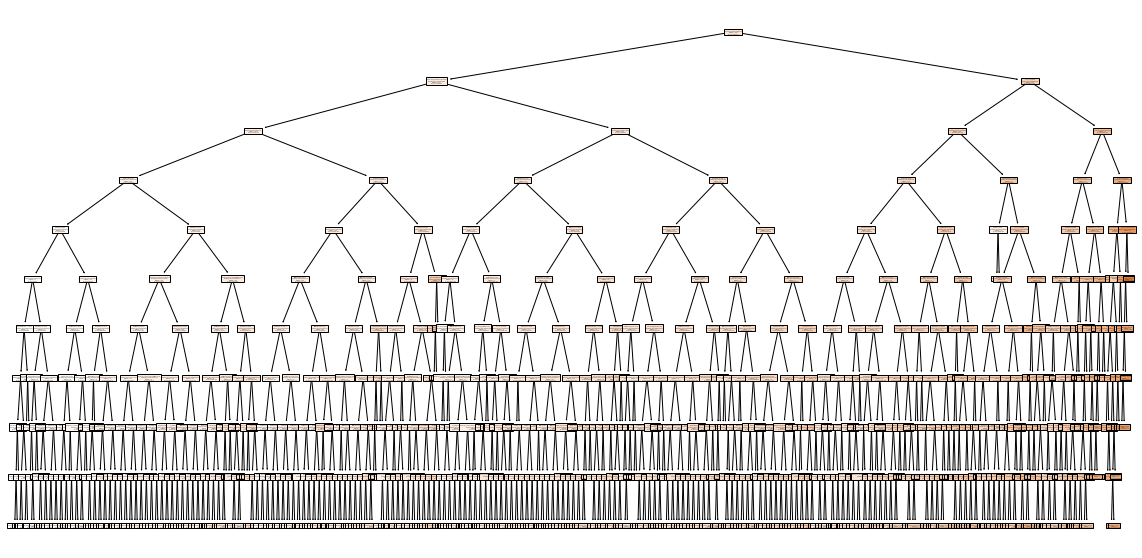

In [31]:
# Visualize decision tree
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

feature_names_list = all_features.tolist()


plt.figure(figsize=(20, 10))
plot_tree(surrogate_model, feature_names=feature_names_list, filled=True)
plt.savefig('surrogate_tree.png')
plt.show()

In [33]:
from sklearn.tree import export_text

tree_rules = export_text(surrogate_model, feature_names=feature_names_list, spacing=3)

# Print the text-based decision tree
print(tree_rules)


|--- OverallQual <= 7.50
|   |--- Neighborhood_encoded <= 180770.84
|   |   |--- 1stFlrSF <= 1050.50
|   |   |   |--- OverallQual <= 4.50
|   |   |   |   |--- GrLivArea <= 842.50
|   |   |   |   |   |--- OverallCond <= 4.50
|   |   |   |   |   |   |--- DistanceFromCenter <= 3.10
|   |   |   |   |   |   |   |--- BedroomAbvGr <= 1.50
|   |   |   |   |   |   |   |   |--- BsmtUnfSF <= 464.00
|   |   |   |   |   |   |   |   |   |--- GarageYrBlt <= 1941.00
|   |   |   |   |   |   |   |   |   |   |--- value: [34494.00]
|   |   |   |   |   |   |   |   |   |--- GarageYrBlt >  1941.00
|   |   |   |   |   |   |   |   |   |   |--- value: [39296.66]
|   |   |   |   |   |   |   |   |--- BsmtUnfSF >  464.00
|   |   |   |   |   |   |   |   |   |--- value: [48081.16]
|   |   |   |   |   |   |   |--- BedroomAbvGr >  1.50
|   |   |   |   |   |   |   |   |--- BsmtQual <= 2.50
|   |   |   |   |   |   |   |   |   |--- BsmtCond <= 2.50
|   |   |   |   |   |   |   |   |   |   |--- value: [64420.01]
|   |   | 

In [48]:
from sklearn.tree import export_graphviz
import graphviz

# Export as dot file
export_graphviz(surrogate_model, out_file='tree.dot', 
                feature_names = feature_names_list,
                filled = True, rounded = True)

# Use graphviz to read the dot file
with open("tree.dot") as f:
    dot_graph = f.read()

# Create a Source object
source = graphviz.Source(dot_graph)

# Render and save to PDF
source.render(filename='surrogate_tree_2', format='pdf', cleanup=True)

'surrogate_tree_2.pdf'